In [3]:
from __future__ import division

In [4]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append('..')

In [5]:
import datetime
import math
from collections import OrderedDict

In [6]:
import numpy as np

In [7]:
import pandas as pd
pd.options.display.max_rows = 999

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [9]:
import tensorflow as tf
import xgboost as xgb

In [10]:
from keras import backend as K
from keras import regularizers

from keras.layers import Dense
from keras.objectives import binary_crossentropy
#from keras.objectives import sigmoid_cross_entropy_with_logits


from keras.metrics import binary_accuracy

Using TensorFlow backend.


# Overview

The goal is to build a classifier that identifies "signal" events with minimal "background" events.  This task is somewhat unique in that the metric is achieving a high statistical significance for events classified as being signal of actually coming from Higgs processes.

The physical processes leading to signal and background are as follows

Signal:

$H \rightarrow \tau \tau \rightarrow l h$

Background:
- $Z \rightarrow \tau \tau \rightarrow lh$
- $t \bar{t} \rightarrow l \tau$
- $W \rightarrow l \tau$


Each event has:
- 1 tau (hadronic)
- 1 lepton (e or mu)
- 0 to 3 jets


The Loss function is given by:
    
$AMS = \sqrt{2 (s + b + b_r) log(1 + \frac{s}{b+b_r})  - s}$

where:
- s is the number of true signal events classified as signal (num true positive)
- b is the number of true background events classified as signal (num false positive)
- br is a constant equal to 10

Of note is that the significance depends on the total number of s and b, not just on their ratio.  So, the best model will be able to generate a region with many signal events and few background events.  Note also that each event has a weight associated with it, and the s and b definitions include the event weights when counting the number of true and false positive events.

We will create this region by building a classifier that assignes each event a score/probability of being signal and using a threshold on that score/probability to define our classification region.

There are 2 general approaches we will explore here:
- Generate a classifier to separate s from b and then find a threshold on that classifier which gives an optimal value of the loss function
- Create a loss function that includes the significance definition above and fit a classifier that directly separates signal from background in a way that is optimal given the loss function

The first approach is somewhat straight-forward.  The second approach requires some discussion.

The loss function above depends on the values s and b, which depend on hard labels of signal/background classifications.  Therefore, it is not differentiable.  In order to use it as a loss function in a fit, we need to write a continuous/differentiable version of it.  Our classifier will generate probabilities of signal for each event $p_i$.  We can use those to define continuous versions of s and b:

$s = \sum_i p_i T_i$
$s = \sum_i p_i (1-T_i)$

where $T_i$ is the true label for the ith event ($T_i \in {0,1}$).

We can then plug this into our loss function:


$Loss(\vec{P}, \vec{T})^2 = 2 (b_r + \sum_i P_i*T_i + (1-T_i)*P_i) log(1 + \frac{\sum_i P_i*T_i }{b_r + \sum_i (1-T_i)*P_i})  - \sum_i P_i*T_i$

$Loss(\vec{P}, \vec{T})^2 = 2 (b_r + \sum_i P_i) log(1 + \frac{\sum_i P_i*T_i }{b_r + \sum_i (1-T_i)*P_i})  - \sum_i P_i*T_i$

And we can also use a simplified version of the loss function, in case this is valuabl:


$Loss(s, b) = \frac{s}{\sqrt{b + br}}$

$Loss(s, b) = \frac{\sum_i P_i T_i}{\sqrt{br + \sum_i P_i (1-T_i)}}$



# Gather the data

We have pre-processed the data in two ways.

First, we have added a number of new features to the data based on our physical domain expertese.  Second, we've divided the "training" data into 3 parts:

- Training, for actually fitting the model
- Evaluation, for any hyperparameter tuning
- Holdout, for calculating final metrics and determining how well the model performs

In [11]:
training = pd.read_csv('../data/training_processed.csv').set_index('EventId')
evaluation = pd.read_csv('../data/evaluation_processed.csv').set_index('EventId')
holdout = pd.read_csv('../data/holdout_processed.csv').set_index('EventId')

In [12]:
for df in training, evaluation, holdout:
    df['target'] = df.Label.map(lambda l: 1.0 if l=='s' else 0.0)

In [13]:
# List all features
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]

In [14]:
info = []

for name, ds in [('training', training), ('evaluation', evaluation), ('holdout', holdout)]:
    i = OrderedDict()
    i['name'] = name
    i['size'] = len(ds)
    i['num_sig'] = len(ds[ds.Label=='s'])
    i['num_bkg'] = len(ds[ds.Label=='b'])
    i['frac'] = i['num_sig'] / (i['num_sig'] + i['num_bkg'])
    i['weight'] = ds.Weight.sum()
    i['weight_sig'] = ds[ds.Label=='s'].Weight.sum()
    i['weight_bkg'] = ds[ds.Label=='b'].Weight.sum()
    i['weight_frac_sig'] = i['weight_sig'] / (i['weight_sig'] + i['weight_bkg'])
    info.append(i)

ds_info = pd.DataFrame(info)
ds_info.T

,0,1,2
name,training,evaluation,holdout
size,175000,7500,13500
num_sig,59907,2616,4697
num_bkg,115093,4884,8803
frac,0.342326,0.3488,0.347926
weight,288162,12180.4,22105.9
weight_sig,481.381,21.6271,38.6838
weight_bkg,287681,12158.7,22067.2
weight_frac_sig,0.00167052,0.00177557,0.00174993


In [15]:
training.head(8).T

EventId,169991,298665,172761,106821,206736,287061,340155,285684
DER_mass_MMC,91.047,100.649,89.712,109.219,125.944,151.992,135.123,386.03
DER_mass_transverse_met_lep,52.939,66.684,25.098,12.33,24.735,47.78,0.711,87.859
DER_mass_vis,72.191,80.55,59.453,79.633,88.551,116.131,90.668,309.873
DER_pt_h,2.141,2.719,30.61,32.764,21.793,17.07,78.708,39.555
DER_deltaeta_jet_jet,-999,-999,2.607,0.699,-999,-999,-999,1.374
DER_mass_jet_jet,-999,-999,214.658,86.099,-999,-999,-999,140.552
DER_prodeta_jet_jet,-999,-999,-0.512,0.195,-999,-999,-999,1.327
DER_deltar_tau_lep,2.976,2.767,2.461,2.482,2.921,3.105,2.304,4.32
DER_pt_tot,2.141,2.719,24.8,18.3,23.619,17.07,15.7,36.554
DER_sum_pt,56.547,75.466,167.624,160.361,131.859,91.603,165.438,268.859


## Plot the features

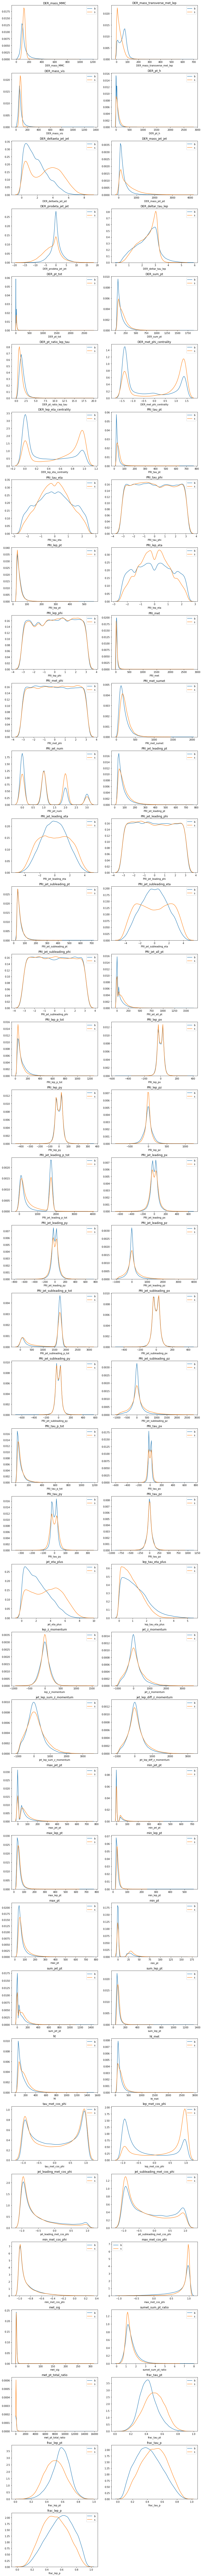

In [14]:
num_features = len(feature_cols)
ncols, nrows = 2, math.ceil(num_features / 2)

fig = plt.figure(figsize=(12, 4*nrows))

labels = training.Label.unique()

for i, f in enumerate(feature_cols):
    
    plt.subplot(nrows, ncols, i+1)
                  
    for label in ['b', 's']:
        sns.distplot(training[(training.Label==label) & (training[f] > -900)][f].dropna(), label=label, ax=plt.gca(),
                     hist=False, rug=False)            
    plt.title(f)
        
plt.tight_layout()

In [16]:
# We hand select a number of features that appear to show
# good discrimination

selected_features = [
    'DER_mass_MMC',
    'DER_mass_transverse_met_lep',
    'DER_mass_vis',
    'DER_pt_h',
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_deltar_tau_lep',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'DER_met_phi_centrality',
    'DER_lep_eta_centrality',
    'PRI_tau_pt',
    'PRI_tau_eta',
    'PRI_lep_eta',
    'PRI_jet_num',
    'PRI_jet_leading_eta',
    'PRI_jet_subleading_eta',
    'PRI_jet_all_pt',
    'jet_eta_plus',
    'lep_tau_eta_plus',
    'min_pt',
    'lep_met_cos_phi',
    'jet_subleading_met_cos_phi',
    'max_met_cos_phi',
    'frac_tau_pt'
]


# Helper Functions

Create some functions to calculate the loss function

In [16]:
def ams2(s, b):
    br = 10    
    arg = 2 * ((s + b + br) * math.log(1 + s/(b + br)) - s)
    return math.sqrt(arg)
    

def ams3(s, b):
    br = 10 
    return s / math.sqrt(b + br)
   

def ams_foo(probs, labels, weights, verbose=False):     
    
    # We use the predicted score to make 0, 1 labels
    pred_label = (probs >= 0.50)
    
    s = (pred_label*labels*weights).sum()
    b = (pred_label*(1.0-labels)*weights).sum()
    br = 10
    
    arg = 2 * (s + b + br) * math.log(1 + (s)/(b + br)) - s
    
    res = math.sqrt(arg)
    
    if verbose:
        print "s={} b={} s/sqrt(b+br)={} ams={}".format(s, b, s / np.sqrt(br), res)
    
    return res

Create a function to visualize the result of a model.
Assume that we have scores, targets, and weights for each row in a dataset.




In [17]:
from sklearn.metrics import auc

def create_result_df(scores, labels, weights):
    
    df = pd.DataFrame({
        'score': scores,
        'label': labels,
        'weight': weights
    })
    
    assert scores.index.equals(labels.index)
    assert scores.index.equals(weights.index)
    
    mn = min(0.0, np.percentile(scores, 2))
    mx = min(1.0, np.percentile(scores, 98))
    
    #mn, mx =  #min(scores), max(scores))
    #mx = min(mn, 0.0)
    #mx = max(mx, 1.0)
    delta = mx - mn    
    thresholds = np.arange(mn, mx, delta/100)
    
    res = []
    
    for t in thresholds:
        
        d = df[df.score >= t]
        
        r = OrderedDict()
        r['threshold'] = t
        r['count'] = len(d)
        r['num_sig'] = len(d[d.label == 's'])
        r['num_bkg'] = len(d[d.label == 'b'])
        r['weight'] = d.weight.sum()
        
        r['s'] = d[d.label=='s'].weight.sum()
        r['b'] = d[d.label=='b'].weight.sum()
        
        r['ams2'] = ams2(r['s'], r['b'])
        r['ams3'] = ams3(r['s'], r['b'])                
        
        n_tp = len(df[(df.score >= t) & (df.label == 's')])
        n_tn = len(df[(df.score < t) & (df.label == 'b')])                

        w_tp = df[(df.score >= t) & (df.label == 's')].weight.sum()
        w_tn = df[(df.score < t) & (df.label == 'b')].weight.sum()

        n_fn = len(df[df.score < t]) - n_tn
        w_fn = df[df.score < t].weight.sum() - w_tn
        
        n_fp = len(d) - n_tp
        w_fp = d.weight.sum() - w_tp
        
        r['accuracy'] = (n_tp + n_tn) / len(df)
        r['accuracy_wgt'] = (w_tp + w_tn) / df.weight.sum()
        
        r['true_positive_rate'] = n_tp / (n_tp + n_fn)
        r['true_positive_rate_wgt'] = w_tp / (w_tp + w_fn)
        
        r['false_positive_rate'] = n_fp / (n_fp + n_tn)
        r['false_positive_rate_wgt'] = w_fp / (w_fp + w_tn)
                
        res.append(r)
        
    return df, pd.DataFrame(res).set_index('threshold', drop=False)

In [18]:
from sklearn.metrics import auc

def summarize_results(results_df):
    pass


def plot_results(df_scores, df_summary):
    
    fig = plt.figure(figsize=(12,12))
    
    plt.subplot(3, 2, 1)
    for l in ['b', 's']:
        sns.distplot(
            df_scores[df_scores.label == l].score,
            label=l,
            ax=plt.gca(),
            hist=False,
            rug=False)
    plt.legend(loc='best')
    plt.title("Individual distributions of score within each class")
        
    plt.subplot(3, 2, 2)
    df_summary.b.plot(label='b')  
    df_summary.s.plot(label='s')
    plt.legend(loc='best')
    plt.title("s and b as a function of threshold")
    plt.gca().set_yscale("log", nonposy='clip')

    plt.subplot(3, 2, 3)
    mn, mx = df_summary.threshold.min(), df_summary.threshold.max()
    plt.hist(df_scores[df_scores.label=='b'].score,
             weights=df_scores[df_scores.label=='b'].weight,
             bins=np.arange(mn, mx, (mx-mn) / 100),
             label='b',
             stacked=True)
    plt.hist(df_scores[df_scores.label=='s'].score,
             weights=df_scores[df_scores.label=='s'].weight,
             bins=np.arange(mn, mx, (mx-mn) / 100),
             label='s',
             stacked=True)    
    plt.gca().set_yscale("log", nonposy='clip')
    plt.legend(loc='best')
    plt.title("Weighted histograms of score distributions (stacked)")
    plt.xlabel('score')
        
    plt.subplot(3, 2, 4)
    df_summary.ams2.plot(label='ams2 (max={:.2f})'.format(df_summary.ams2.max()))
    df_summary.ams3.plot(label='ams3 (max={:.2f})'.format(df_summary.ams3.max()))
    plt.xlabel('Threshold')
    plt.ylabel('AMS Metric')
    plt.legend(loc='best')
    plt.title("Metrics as a function of threshold")    
    
    plt.subplot(3, 2, 5)        
    x = df_summary['false_positive_rate']
    y = df_summary['true_positive_rate']
    roc_auc = auc(x, y, reorder=True)
    plt.plot(x, y, label='ROC Curve     (AUC={:.3f})'.format(roc_auc))    
    x = df_summary['false_positive_rate_wgt']
    y = df_summary['true_positive_rate_wgt']
    roc_auc = auc(x, y, reorder=True)
    plt.plot(x, y, label='ROC Curve WGT (AUC={:.3f})'.format(roc_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate") 
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    
    plt.subplot(3, 2, 6) 
    df_summary.accuracy.plot(label='Accuracy') # (max={:.3f})'.format(df_summary.accuracy.max()))
    df_summary.accuracy_wgt.plot(label='Accuracy WGT') # (max={:.3f})'.format(df_summary.accuracy_wgt.max()))
    plt.legend(loc='best')
    
    plt.tight_layout()
    
    

# Train Models

## Naive Bayes

Good practice is to always start with the simplest model that could possibly work.  For classification, we generally like to begin with logistic regression, as it's extremely common and useful.  However, on a first examination of the features, few of them are monotonic in the ratio of signal to background, and therefore the core assumption of logistic regression (that the log odds are linear in the features) appears to be violated.

We could do some simple feature transformations to recover this assumption, but we'll here just switch to another simple model that can handle these feature distributions: Naive Bayes.

In [19]:
from sklearn.naive_bayes import GaussianNB

In [20]:
naive_bayes = GaussianNB()
naive_bayes.fit(training[selected_features], training.target)

GaussianNB(priors=None)

In [21]:
nb_predictions = pd.Series(naive_bayes.predict_proba(holdout[selected_features])[:, 1], index=holdout.index)

nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

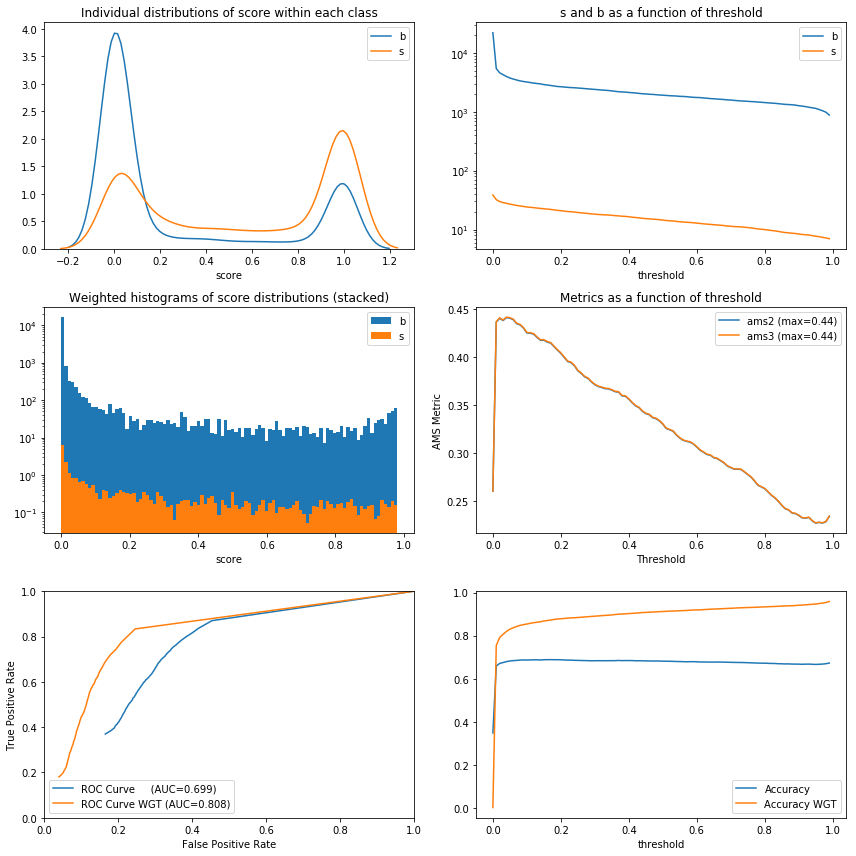

In [22]:
plot_results(nb_score_data, nb_score_summary)

## Gradient Boosted Trees

We next reach for a much more powerful tool: Gradient Boosted Decision Trees via the XGBoost package.  We will first use this as a tool for building a score.  However, XGBoost allows one to customize a loss function, which we will later use to incorporate our custom loss function directly into the fitting step.

In [23]:
%aimport xg_predictor

In [24]:
gbt = xg_predictor.XGPredictor(
    num_round=50,
    early_stopping_rounds=10,
    **{
    'max_depth': 4,
    'eta': .4,
    'silent': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'gamma': 10.0,
    'min_child_weight': 10,
    'lambda': 1.0,
    'scale_pos_weight': 1
    })


gbt.fit(training[feature_cols], training.target, None, #training.Weight,
        evaluation[feature_cols], evaluation.target, None) #evaluation.Weight)

[0]	train-auc:0.84791	eval-auc:0.850938
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.869369	eval-auc:0.871755
[2]	train-auc:0.876968	eval-auc:0.880248
[3]	train-auc:0.880887	eval-auc:0.884054
[4]	train-auc:0.886032	eval-auc:0.888675
[5]	train-auc:0.88904	eval-auc:0.891407
[6]	train-auc:0.891784	eval-auc:0.894141
[7]	train-auc:0.894232	eval-auc:0.896108
[8]	train-auc:0.89607	eval-auc:0.898194
[9]	train-auc:0.897002	eval-auc:0.898783
[10]	train-auc:0.89807	eval-auc:0.899911
[11]	train-auc:0.899816	eval-auc:0.901575
[12]	train-auc:0.900786	eval-auc:0.902258
[13]	train-auc:0.901678	eval-auc:0.902732
[14]	train-auc:0.90248	eval-auc:0.903389
[15]	train-auc:0.902955	eval-auc:0.903856
[16]	train-auc:0.903478	eval-auc:0.904145
[17]	train-auc:0.904349	eval-auc:0.904391
[18]	train-auc:0.905006	eval-auc:0.904845
[19]	train-auc:0.905461	eval-auc:0.905437
[20]	train-auc:0.905843	eval-auc:0

In [25]:
gbt_predictions = gbt.predict_raw(holdout)

gbt_score_data, gbt_score_summary = create_result_df(gbt_predictions, holdout.Label, holdout.Weight)

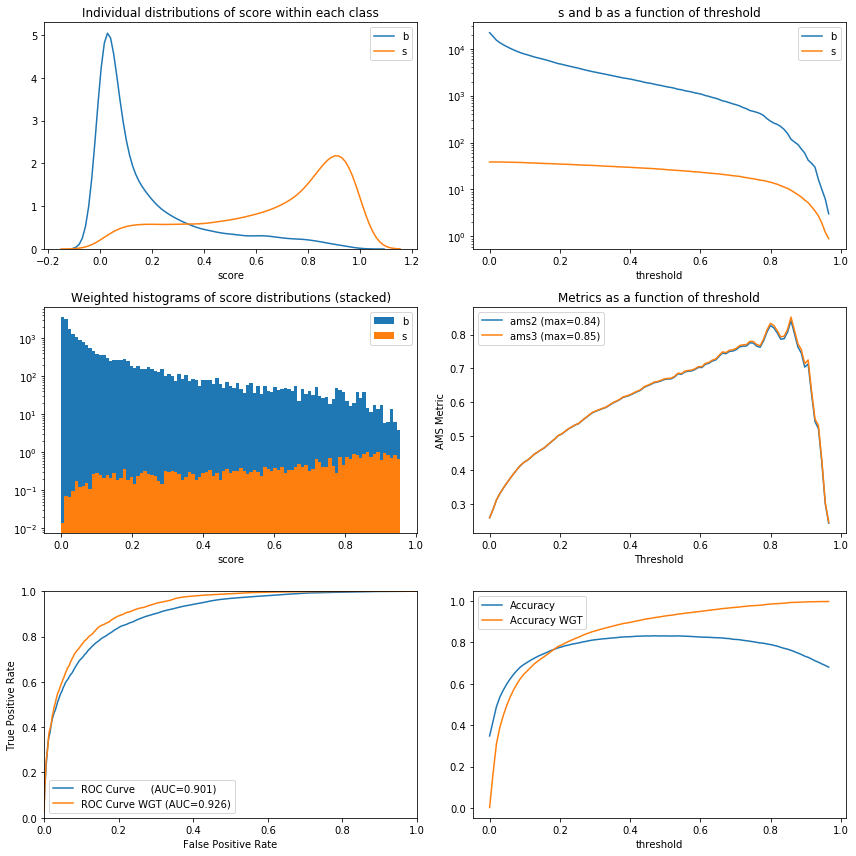

In [26]:
plot_results(gbt_score_data, gbt_score_summary)

We see that we are able to create a strong classifier using gradient boosted trees, with a ROC-AUC value > 0.90.  One thing we discovered during this process was that we end up building a better classifier when we don't include the weights in the training data.  This more-or-less balances the training data, as opposed to using the weights, which results in highly imbalanced training data.

The question is whether we can use the weights effectively in the training stage. The training could, in priciniple, use the weights and knowledge of our overall loss function to build a classifier that creates higher significance. 

## Hybrid XGBoost

We attempt to update the loss function of our xgboost model to incorporate weights and the target loss function.  A custom XGBoost loss function requires defining the gradients and hessians of the loss as a function of the output model scores (XGBoost internally uses this information in the building of the trees).

We could by-hand calculate the gradient and hesse.  But, as we explore, we may want to make adjustments to the loss function we're using in XGBoost.  And calculating derivitives over and over could be cumbersome and error-prone.

Instead, we're going to use Tensorflow to calculate the gradients and feed those into XGBoost's loss function

In [27]:
# Define the loss graph
xgb_graph = tf.Graph()

with xgb_graph.as_default():
    
    preds = tf.placeholder(tf.float64, [None, 1], name='preds')
    targets = tf.placeholder(tf.float64, [None, 1], name='targets')
    weights = tf.placeholder(tf.float64, [None, 1], name='weights')
    
    probs = preds

    s = tf.reduce_sum(targets * probs * weights, name='s') #* 1000.0
    b = tf.reduce_sum((1.0-targets) * probs * weights, name='b')
    br = 10.0

    # We use ams3 for the first part of the loss
    loss_a = tf.identity(
        -1.0 * (tf.log(s) - 0.5*tf.log(b + br)),
        name='loss_a')
        
    # We find that we also have to add a bit of cross-entropy to the loss
    # to end up with reasonable results
    loss_b = tf.identity(
        -0.001 * tf.reduce_sum(targets*tf.log(probs)*weights + (1.0-targets)*tf.log(1.0-probs)*weights),
        name='loss_b')
    
    loss = tf.identity(loss_a + loss_b, name='loss')
            
    grad = tf.gradients(loss, preds, name='grad')
    hesse = tf.gradients(grad, preds, name='hesse')


In [28]:
def feval_ams(preds, dset): 
    
    probs = 1.0 / (1.0 + np.exp(-preds))
    labels = dset.get_label()
    weights = dset.get_weight()
    
    s = np.sum([w for p, w, l in zip(probs, weights, labels) if p >= 0.5 and l==1.0])
    b = np.sum([w for p, w, l in zip(probs, weights, labels) if p >= 0.5 and l==0.0])
        
    return 'AMS', ams3(s, b)


def obj_ams(preds, dset):
    
    targets = dset.get_label()
    weights = dset.get_weight()
                
    sess = tf.Session(graph=xgb_graph)
            
    to_calculate = ['loss', 's', 'b', 'loss_a', 'loss_b']
    with sess as s:
        tens_to_calc = [xgb_graph.get_tensor_by_name("{}:0".format(name)) for name in to_calculate] + [grad, hesse]
        results = sess.run(tens_to_calc,
                           feed_dict={
                               xgb_graph.get_tensor_by_name('preds:0'): preds.reshape((len(preds)), 1),
                               xgb_graph.get_tensor_by_name('targets:0'): targets.reshape((len(targets), 1)),
                               xgb_graph.get_tensor_by_name('weights:0'): weights.reshape((len(weights), 1))
                           })
        
        d = OrderedDict()
        for name, val in zip(to_calculate + ['grad', 'hesse'], results):
            d[name] = val
            
        for name, val in d.iteritems():
            if name not in {'grad', 'hesse'}:
                print '{}={}'.format(name, val),
        print ''
            
        return d['grad'][0], d['hesse'][0]
        

In [29]:
gbt_hybrid = xg_predictor.XGPredictor(
    num_round=20,
    **{
    'max_depth': 3,
    'eta': .4,
    'silent': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'gamma': 1.0,
    'min_child_weight': 10,
    'lambda': 0.1,
    'scale_pos_weight': 0
    })

gbt_hybrid.fit(training[feature_cols], training.target, training.Weight,
        feval=feval_ams,
        obj=obj_ams)

loss=200.19376155 s=240.690501869 b=143840.547904 loss_a=0.454753205356 loss_b=199.739008345 
[0]	train-auc:0.5	train-AMS:0.897482
loss=173.142379775 s=216.865461682 b=129602.317447 loss_a=0.506874381191 loss_b=172.635505394 
[1]	train-auc:0.5	train-AMS:0.897482
loss=146.717136231 s=191.293074274 b=114319.843949 loss_a=0.569614786501 loss_b=146.147521445 
[2]	train-auc:0.5	train-AMS:0.897482
loss=121.581321285 s=164.644644745 b=98394.3102268 loss_a=0.64463045939 loss_b=120.936690825 
[3]	train-auc:0.5	train-AMS:0.897482
loss=98.4482403441 s=137.915617861 b=82420.6102173 loss_a=0.733214031709 loss_b=97.7150263124 
[4]	train-auc:0.5	train-AMS:0.897482
loss=77.9792587649 s=112.328812449 b=67129.5202871 loss_a=0.835833667154 loss_b=77.1434250977 
[5]	train-auc:0.744747	train-AMS:0.897482
loss=60.5389771236 s=91.5811182896 b=53190.7966511 loss_a=0.923689206709 loss_b=59.6152879169 
[6]	train-auc:0.787147	train-AMS:0.897482
loss=46.166988852 s=76.5278090661 b=41051.0762853 loss_a=0.973753759

In [30]:
gbt_hybrid_predictions = gbt_hybrid.predict_raw(holdout)

gbt_hybrid_score_data, gbt_hybrid_score_summary = create_result_df(gbt_hybrid_predictions, holdout.Label, holdout.Weight)

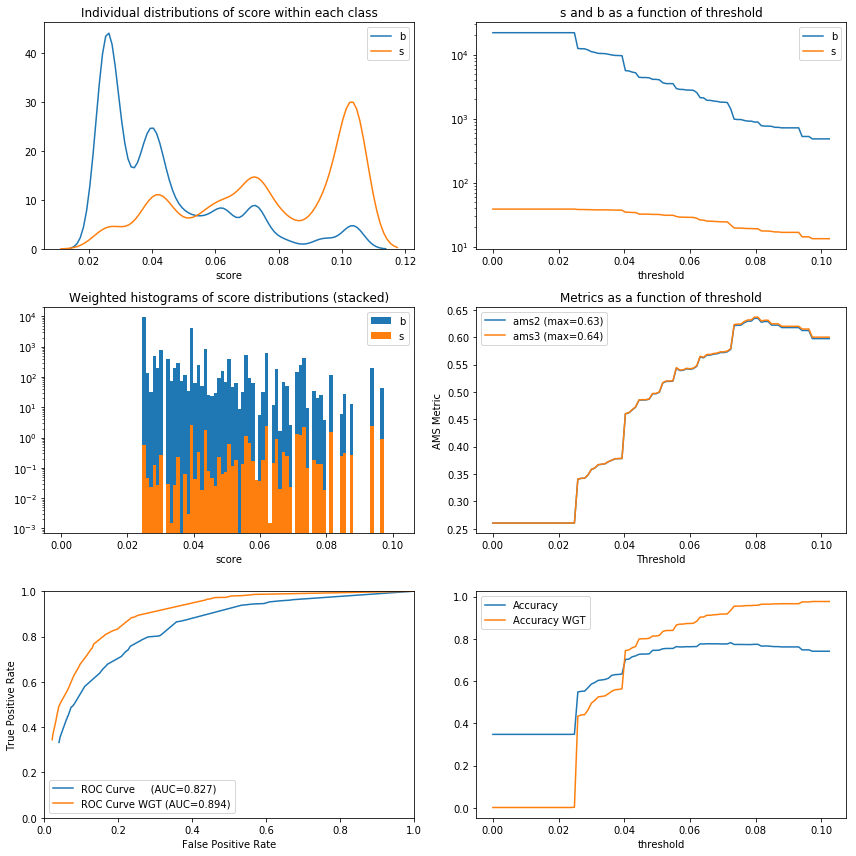

In [31]:
plot_results(gbt_hybrid_score_data, gbt_hybrid_score_summary)

So, we were able to incorporate the weights and the custom loss function directly into the fitting of XGBoost.  However, we find that it ends up hurting the overall performance on our evaluation metric.  In particular, one thing we found was that the fits become very unstable and inaccurate if we only fit against the custom loss function.  We instead had to add a log-loss term to the loss function in order to achieve stability in the fit (otherwise, it ends up making no progress as a function of trees).

Including the weights and the new loss function makes the dynamic range of our score much smaller.  It seems that the trees are not good at adjusting to this custom likelihood function that is driven by large weight imbalances.  Let's see if a smoother model can handle this loss function better.

## Neural Network

We are going to build a neural network model that takes into account our custom loss function and uses our custom weights.  This should give us the ability to make adjustments under-the-hood to ensure smooth fitting of our loss.  The hypothesis is that the flexibility and smoothness of a network will be better able to handle our loss function and may provide better results.

In [45]:
# Preprocess the features:
# Create separate boolean features for if the feature is good or bad (eg = -999)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


class MissingToNa(object):
    
    def fit(self, *x):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X:
            X[col] = np.where(X[col] < -800, np.nan, X[col])
        return X

class AddNaIndicator(object):
    def fit(self, *x):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X:
            X[col+"_is_missing"] = np.where(pd.isnull(X[col]), 1.0, 0.0)
        return X    

pipeline = make_pipeline(MissingToNa(), AddNaIndicator(), Imputer(), StandardScaler())
pipeline.fit(training[feature_cols])

nn_features_training = pipeline.transform(training[feature_cols])
nn_features_evaluation = pipeline.transform(evaluation[feature_cols])
nn_features_holdout = pipeline.transform(holdout[feature_cols])

In [51]:
nn_graph = tf.Graph()

with nn_graph.as_default():
    
    features = tf.placeholder(tf.float32, [None, 150], name='features')
    targets = tf.placeholder(tf.float32,  [None, 1],  name='targets')
    weights = tf.placeholder(tf.float32,  [None, 1],  name='weights')
    
    x = Dense(512,
              activation='relu',
              kernel_regularizer=regularizers.l2(0.1),
              bias_regularizer=regularizers.l2(0.1),
              kernel_initializer='random_uniform',
              bias_initializer='zeros')(features)
    
    x = Dense(512,
              activation='relu',
              kernel_regularizer=regularizers.l2(0.1),
              bias_regularizer=regularizers.l2(0.1),
              kernel_initializer='random_uniform',
              bias_initializer='zeros')(x)
   
    x = Dense(512,
              activation='relu',
              kernel_regularizer=regularizers.l2(0.1),
              bias_regularizer=regularizers.l2(0.1),
              kernel_initializer='random_uniform',
              bias_initializer='zeros')(x)
    
    # Create the predictions via a sigmoid
    logits = Dense(1, activation=None, name='probs')(x)
    probs = tf.sigmoid(logits)
    
    # Create the loss function
    s = tf.reduce_sum(targets * probs * weights, name='s')
    b = tf.reduce_sum((1.0-targets) * probs * weights, name='b')
    br = 10.0

    with tf.name_scope('evaluation') as scope:
        
        # We use ams3 for the first part of the loss
        ams = tf.identity(-1.0 * s / tf.sqrt(b + br), name='ams')            
        ce = tf.identity(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)), name='cross_entropy')
        accuracy = tf.identity(tf.reduce_mean(binary_accuracy(targets, probs)), name='accuracy')
                                    
        eval_summaries = tf.identity(tf.summary.merge([
            tf.summary.scalar('eval_ams', ams),
            tf.summary.scalar('eval_cross_entropy', ce),
            tf.summary.scalar('eval_accuracy', accuracy),
            tf.summary.histogram('eval_probs', probs)
        ]),
            name='eval_summaries')
        
        train_summaries = tf.identity(tf.summary.merge([
            tf.summary.scalar('train_ams', ams),
            tf.summary.scalar('train_cross_entropy', ce),
            tf.summary.scalar('train_accuracy', accuracy),
            tf.summary.histogram('train_probs', probs)
        ]),
            name='train_summaries')       
    
    with tf.name_scope('training') as scope:
        train_ce = tf.train.AdamOptimizer(learning_rate=0.001, epsilon=0.1).minimize(ce, name='train_ce')
        train_ams = tf.train.AdamOptimizer(learning_rate=0.001, epsilon=0.1).minimize(ams, name='train_ams')
    
    # Initialize all variables
    init_op = tf.global_variables_initializer()

In [52]:
len(training)

175000

In [59]:
class BatchIterator(object):
    
    def __init__(self, batch_size, *Xs):
    
        self._length = len(Xs[0])
    
        assert self._length % batch_size == 0
    
        for X in Xs:
            assert len(X) == self._length
            
        self._batch_size = batch_size
        self._Xs = list(Xs)
        
    def batch_idx_iterator(self):
        return xrange(0, self._length // self._batch_size)
            
    def get_batch(self, batch_idx):
        
        slices = []
    
        begin = batch_idx * self._batch_size
        end = (batch_idx+1) * self._batch_size
    
        for X in self._Xs:
            slices.append(X[begin:end])
            
        return slices
            
        

In [60]:
num_epochs = 30
batch_size = 100

batches = BatchIterator(
    batch_size,
    nn_features_training,
    training.target.values.reshape(len(training), 1),
    training.Weight.values.reshape(len(training), 1))

num_batch = 0
with tf.Session(graph=nn_graph) as sess:
          
    K.set_session(sess)
    sess.run(init_op)
    
    file_writer = tf.summary.FileWriter('./tensorboard/nn_{}'.format(datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")))

    print "Starting Training"
    
    for epoch_idx in range(num_epochs):
    
        for j in batches.batch_idx_iterator():
            num_batch += 1
            batch_features, batch_target, batch_weight = batches.get_batch(j)

                # Switch loss half way through
            if epoch_idx < 20:
                train_step = train_ce
            else:
                train_step = train_ams
                                
            train_step.run(feed_dict={features: batch_features,
                                      targets: batch_target,
                                      weights: batch_weight})
         
        # At the end of the epoch, print summary info
        (eval_ams, eval_ce, eval_accuracy, eval_info) = sess.run([
                        ams,
                        ce,
                        accuracy,
                        eval_summaries],
                        feed_dict={
                            features: nn_features_evaluation,
                            targets: evaluation.target.values.reshape(len(evaluation), 1),
                            weights: evaluation.Weight.values.reshape(len(evaluation), 1)})
        file_writer.add_summary(eval_info, epoch_idx)

        train_info = sess.run(train_summaries, feed_dict={
            features: nn_features_training,
            targets: training.target.values.reshape(len(training), 1),
            weights: training.Weight.values.reshape(len(training), 1)})
        file_writer.add_summary(train_info, epoch_idx)
        
        print ("Epoch {:2} Batch Overall: {:6} Num Rows: {} " + \
              "Acc: {:.4f} AMS: {:.4f} CrossEntropy: {:.4f}").format(
                  epoch_idx, num_batch, num_batch*batch_size,
                  eval_accuracy, eval_ams, eval_ce)
        
    file_writer.close()    
    
    (holdout_probs,) = sess.run([probs],
                     feed_dict={
                         features: nn_features_holdout,
                         targets: holdout.target.values.reshape(len(holdout), 1),
                         weights: holdout.Weight.values.reshape(len(holdout), 1)})

Starting Training
Epoch  0 Batch Overall:   1750 Num Rows: 175000 Acc: 0.7664 AMS: -0.2305 CrossEntropy: 0.4802
Epoch  1 Batch Overall:   3500 Num Rows: 350000 Acc: 0.8117 AMS: -0.2847 CrossEntropy: 0.4195
Epoch  2 Batch Overall:   5250 Num Rows: 525000 Acc: 0.8317 AMS: -0.3119 CrossEntropy: 0.3887
Epoch  3 Batch Overall:   7000 Num Rows: 700000 Acc: 0.8352 AMS: -0.3201 CrossEntropy: 0.3785
Epoch  4 Batch Overall:   8750 Num Rows: 875000 Acc: 0.8384 AMS: -0.3235 CrossEntropy: 0.3738
Epoch  5 Batch Overall:  10500 Num Rows: 1050000 Acc: 0.8392 AMS: -0.3254 CrossEntropy: 0.3708
Epoch  6 Batch Overall:  12250 Num Rows: 1225000 Acc: 0.8403 AMS: -0.3272 CrossEntropy: 0.3687
Epoch  7 Batch Overall:  14000 Num Rows: 1400000 Acc: 0.8404 AMS: -0.3285 CrossEntropy: 0.3671
Epoch  8 Batch Overall:  15750 Num Rows: 1575000 Acc: 0.8409 AMS: -0.3298 CrossEntropy: 0.3658
Epoch  9 Batch Overall:  17500 Num Rows: 1750000 Acc: 0.8389 AMS: -0.3306 CrossEntropy: 0.3648
Epoch 10 Batch Overall:  19250 Num Ro

In [61]:
holdout_probs = pd.Series(holdout_probs.reshape((len(holdout_probs),)), index=holdout.index)

nn_score_data, nn_score_summary = create_result_df(holdout_probs, holdout.Label, holdout.Weight)

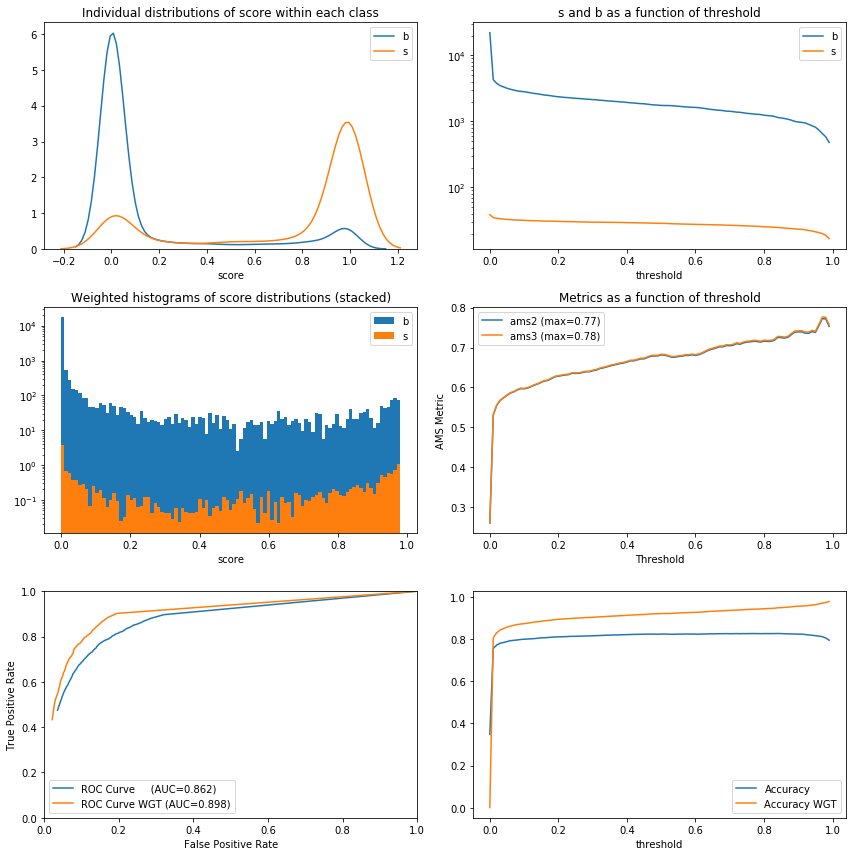

In [62]:
plot_results(nn_score_data, nn_score_summary)

In [ ]:
raise Exception()

# OTHER

In [ ]:
class XGBoostModel(object):
    
    def __init__(self, feature_names, df_evaluation=None):
        self._feature_names = list(feature_names)
        self._df_evaluation = df_evaluation       
        
    def grad_hesse(self, preds, dtrain):
        
        labels = dtrain.get_label()
        weights = dtrain.get_weight()
                
        sess = tf.Session(graph=xgb_graph)
            
        to_calculate = ['loss', 's', 'b', 'loss_a', 'loss_b', 'grad', 'hesse']
            
        with sess as s:
            
            to_calculate = [xgb_graph.get_tensor_by_name("{}:0".format(name)) for name in to_calculate]
                        
            results = sess.run(to_calculate,
                               feed_dict={
                                       self._preds: preds.reshape((len(preds)), 1),
                                       self._labels: labels.reshape((len(labels), 1)),
                                       self._weights: weights.reshape((len(weights), 1))
                                   })
            
        for name, val in zip(to_calculate, results):
            print '{}={}'.format(name, val),
        print ''
            
        #print "loss={:.5f} ({:.5f}, {:.5f}) s={} b={}".format(loss, loss_a, loss_b, sig, bkg)
        #print "loss={} ({}, {}) s={} b={} s/sqrt(b+br)={}".format(loss, loss_a, loss_b, sig, bkg, sig / np.sqrt(bkg + 10))
        return grad[0], hesse[0]

            
    def make_dmatrix(self, X, y, weight):
        label = y.map(lambda x: 1.0 if x == 's' else 0.0)        
        return xgb.DMatrix(X[self._feature_names],
                           label=label,
                           weight=weight,
                           feature_names=self._feature_names)
        
        
    def fit(self, X, y, weight):
                
        param = {'max_depth': 5,
                 'eta': .1,
                 'silent': 1,
                 #'objective': 'binary:logistic',
                 'eval_metric': 'auc',
                 'gamma': 10.0,
                 'min_child_weight': 0,
                 'lambda': 0.0,
                 'scale_pos_weight': 1
                 }
        
        param['nthread'] = 4
        
        dtrain = self.make_dmatrix(X, y, weight)
        evallist = [(dtrain, 'train')]
        
        if self._df_evaluation is not None:

            matrix = self.make_dmatrix(
                self._df_evaluation,
                self._df_evaluation.Label,
                self._df_evaluation.Weight)
            
            evallist.append((matrix, 'eval'))
        
        num_round = 30
        
        # early_stopping_rounds=15, 
        bst = xgb.train(param.items(), dtrain, num_round, evallist,
                        feval=feval_ams,
                        obj=lambda x, T: self.grad_hesse(x, T),  
                        verbose_eval=True)
        
        self._fitted = bst
    
    def predict_raw(self, ds):
        dset = self.make_dmatrix(ds,
                ds.Label,
                ds.Weight)
        return pd.Series(self._fitted.predict(dset), index=ds.index)
    
    def predict_proba(self, ds):
        raws = self.predict_raw(ds)
        return pd.Series(1 / (1.0 + np.exp(-1*raws)), index=ds.index)
        

In [ ]:
boosted_trees = XGBoostModel(features_to_use, evaluation)
boosted_trees.fit(training, training['Label'], training['Weight'])

In [ ]:
y_hat_holdout = boosted_trees.predict_proba(holdout)

probs = y_hat_holdout
true_target = holdout.Label.map(lambda l: 1.0 if l=='s' else 0.0)
weights = holdout.Weight
pred_label = (probs >= 0.50)

ams(probs,
    true_label,
    weights,
    verbose=True)

holdout_summary = pd.DataFrame({
    'probs': probs,
    'true_label': holdout.Label,
    'target': true_target,
    'weights': weights,
    'pred_lablel': pred_lablel})

In [ ]:
pred_label.value_counts()

In [ ]:
print (pred_label*(1.0-true_label)*weights).sum()
print (pred_label*(true_label)*weights).sum()
print (pred_label*(1.0-true_label)*weights).sum() + (pred_label*(true_label)*weights).sum()
print (weights*pred_label).sum()

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
holdout_summary.probs.hist()

plt.subplot(3, 1, 2)
holdout_summary.probs.hist(bins=np.arange(0.0, 1.01, 0.01))

plt.subplot(3, 1, 3)
for label in ['b', 's']:
    try:
        sns.distplot(
            holdout_summary[holdout_summary.true_label == label].probs,
            label=label,
            ax=plt.gca(),
            hist=False,
            rug=False)
    except Exception as e:
        print "unable to plot"
        break      

plt.tight_layout()

In [ ]:
import numpy as np

sess = tf.Session(graph=graph)
with sess as s:
    
    vals = sess.run([ams_2, grad, hesse],
                   feed_dict={xs: np.array([1, 2, 3, 4, 5]).reshape((5, 1)),
                              T: np.array([1, 0, 1, 1, 1]).reshape((5, 1))})
    
    for val in vals:
        print val
        print ''

In [ ]:
import pandas as pd
df_raw = pd.read_csv('../data/training.csv').set_index('EventId')

In [ ]:
df_raw.head(3).T

In [ ]:
%aimport features

In [ ]:
features._calculate_momenta(df_raw.head(), 'PRI_jet_subleading_')

In [ ]:
features.with_momentum_features(df_raw.head(3)).T